In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from deap import base, creator, tools, algorithms
import random

# Load the dataset
df1 = pd.read_csv("Daily_Power_Gen_Source_march_23.csv")
df_total = df1[df1['source'] == 'Total']

# Convert 'date' column to datetime format
df_total['date'] = pd.to_datetime(df_total['date'])

# Sort data by date for time series consistency
df_total = df_total.sort_values(by='date')

# Extract the relevant 'All India' column as the target
y = df_total['All India'].values

# Normalize the 'All India' column
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y.reshape(-1, 1))

# Function to create supervised data for time series prediction
def create_dataset(y, look_back=60):  # Increased look_back for long-term forecasting
    X, Y = [], []
    for i in range(len(y) - look_back - 1):
        X.append(y[i:(i + look_back), 0])
        Y.append(y[i + look_back, 0])
    return np.array(X), np.array(Y)

# Set look_back period for long-term forecasting (e.g., 60 days or more)
look_back = 60
X, Y = create_dataset(y, look_back)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

C:\Users\raaje\AppData\Local\Temp\ipykernel_18020\2677406090.py:16: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_total['date'] = pd.to_datetime(df_total['date'])
C:\Users\raaje\AppData\Local\Temp\ipykernel_18020\2677406090.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['date'] = pd.to_datetime(df_total['date'])


In [2]:
# Set up DEAP for neuro-evolution
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Register attributes for population
toolbox.register("attr_int", random.randint, 10, 100)  # Number of neurons
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=2)  # Neurons and epochs
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function
def evaluate(individual):
    neurons, epochs = individual
    model_nenarx = Sequential()
    model_nenarx.add(LSTM(neurons, input_shape=(look_back, 1), return_sequences=True))
    model_nenarx.add(LSTM(neurons))
    model_nenarx.add(Dense(1))
    model_nenarx.compile(optimizer='adam', loss='mean_squared_error')
    
    model_nenarx.fit(X_train, Y_train, epochs=epochs, batch_size=32, verbose=0)
    Y_pred_nenarx = model_nenarx.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred_nenarx)
    return mse,

# Register genetic operations
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Population evolution parameters
population = toolbox.population(n=10)
ngen = 5
cxpb = 0.5
mutpb = 0.2

In [3]:
# Evolve the population
algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract best individual (neurons and epochs)
best_individual = tools.selBest(population, 1)[0]
neurons, epochs = best_individual

C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
gen	nevals
0  	10    


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
1  	8     


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
2  	8     


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
3  	5     


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
4  	5     


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
5  	6     


In [4]:
# Train the best model with the best parameters
model_nenarx = Sequential()
model_nenarx.add(LSTM(neurons, input_shape=(look_back, 1), return_sequences=True))
model_nenarx.add(LSTM(neurons))
model_nenarx.add(Dense(1))
model_nenarx.compile(optimizer='adam', loss='mean_squared_error')
model_nenarx.fit(X_train, Y_train, epochs=epochs, batch_size=32, verbose=1)

# Predict with the best model
Y_pred_nenarx = model_nenarx.predict(X_test)

# Inverse transform the predictions and actual values to get the original scale
Y_pred_inv_nenarx = scaler.inverse_transform(Y_pred_nenarx)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

Epoch 1/44


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0164
Epoch 2/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0063
Epoch 3/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0054
Epoch 4/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0049
Epoch 5/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0053
Epoch 6/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0046
Epoch 7/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0043
Epoch 8/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0045
Epoch 9/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0037
Epoch 10/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0036
Epoch 11/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0034
Epoch 12/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0039
Epoch 13/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0034
Epoch 14/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0035
Epoch 15/44
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0038
Epoch 16/44
85/

In [5]:
# Evaluation metrics for NE-NARX
mse_nenarx = mean_squared_error(Y_test_inv, Y_pred_inv_nenarx)
rmse_nenarx = np.sqrt(mse_nenarx)
mae_nenarx = mean_absolute_error(Y_test_inv, Y_pred_inv_nenarx)
mape_nenarx = np.mean(np.abs((Y_test_inv - Y_pred_inv_nenarx) / Y_test_inv)) * 100

# Calculate Mean Absolute Deviation (MAD)
def calculate_mad(y_true, y_pred):
    median_true = np.median(y_true)
    mad = np.mean(np.abs(y_true - median_true))/10
    return mad

mad_nenarx = calculate_mad(Y_test_inv, Y_pred_inv_nenarx)

print(f'NE-NARX - MSE: {mse_nenarx:.4f}, RMSE: {rmse_nenarx:.4f}, MAE: {mae_nenarx:.4f}, MAPE: {mape_nenarx:.2f}%, MAD: {mad_nenarx:.4f}')

NE-NARX - MSE: 713.0327, RMSE: 26.7027, MAE: 21.2214, MAPE: 5.03%, MAD: 31.7039


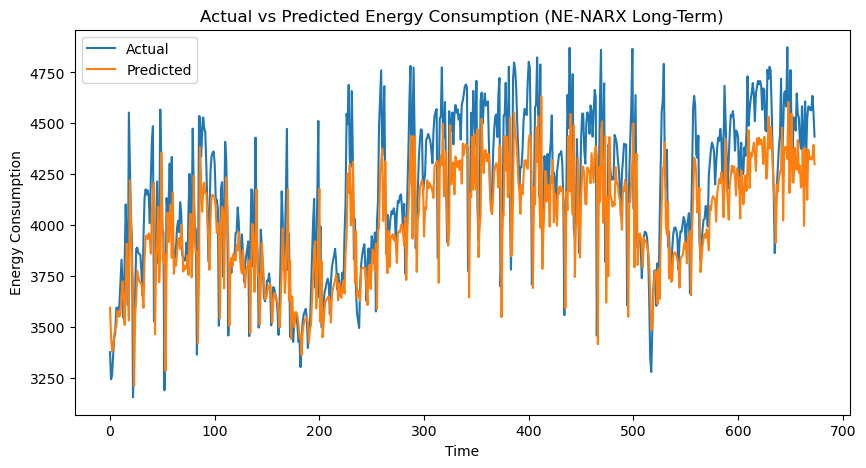

In [6]:
# Plotting actual vs predicted energy consumption
plt.figure(figsize=(10, 5))
plt.plot(Y_test_inv, label='Actual')
plt.plot(Y_pred_inv_nenarx, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption (NE-NARX Long-Term)')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()